# AlexNet Model Implementation
---
## 1. AlexNet 모델 정의
- 구현에 쓰인 학습 데이터셋은 `pytorch.datasets`에 내장된 FashionMNIST를 사용함. 
- 논문과 다르게 입력 채널 수가 1(gray scale), out_features는 데이터셋의 class가 10개이므로 10임.
- GPU 2개 병렬 연산이 포인트지만, GPU가 하나인 관계로 구현하지 못함. 
- 모델을 정의하고 마지막에 summary로 output shape과 parameter 확인

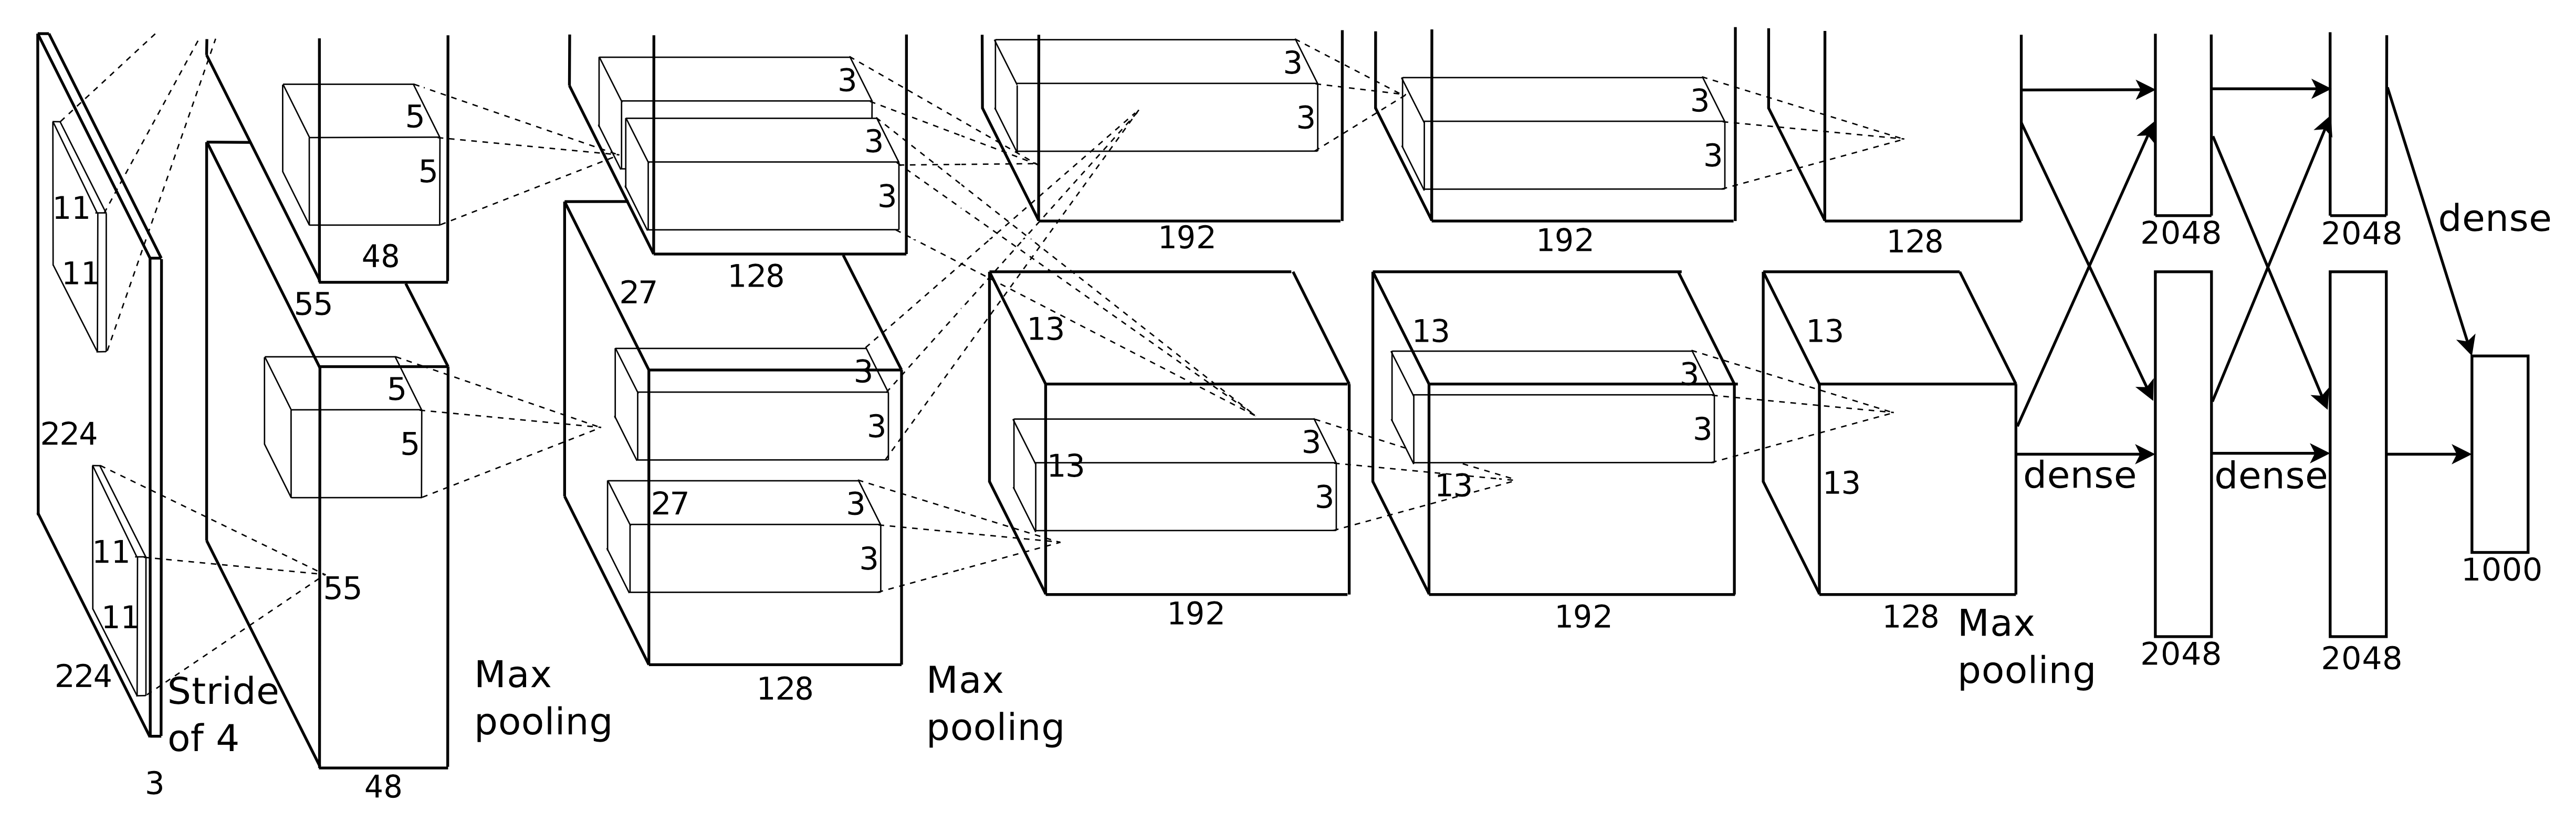

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
from torchvision import transforms, datasets

In [2]:
class AlexNet(nn.Module):
    def __init__(self):
        super(AlexNet, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=96, kernel_size=11, stride=4)
        self.conv2 = nn.Conv2d(in_channels=96, out_channels=256, kernel_size=5, padding=2)
        self.conv3 = nn.Conv2d(in_channels=256, out_channels=384, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(in_channels=384, out_channels=384, kernel_size=3, padding=1)
        self.conv5 = nn.Conv2d(in_channels=384, out_channels=256, kernel_size=3, padding=1)
        
        # fc layer
        self.fc1 = nn.Linear(in_features=256 * 6 * 6, out_features=4096)
        self.fc2 = nn.Linear(in_features=4096, out_features=4096)
        self.fc3 = nn.Linear(in_features=4096, out_features=10)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, kernel_size=3, stride=2)
        
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, kernel_size=3, stride=2)
        
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = F.relu(self.conv5(x))
        x = F.max_pool2d(x, kernel_size=3, stride=2)
        
        # 4차원을 1차원으로 펼쳐주는 층 -> flatten
        x = x.view(x.size(0), -1)
        
        x = F.relu(self.fc1(x))
        x = F.dropout(x, p=0.5)
        
        x = F.relu(self.fc2(x))
        x = F.dropout(x, p=0.5)
        
        x = F.log_softmax(self.fc3(x), dim=1)
        
        return x
    
    @staticmethod
    def transform():
        return transforms.Compose([transforms.Resize((227, 227)),
                                  transforms.ToTensor(), 
                                  transforms.Normalize(mean=(0.1307, ), std=(0.3081, ))])
    
if __name__ == "__main__":
    # if gpu is to be used
    use_cuda = torch.cuda.is_available()
    print("use_cuda : ", use_cuda)
    
    FloatTensor = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor
    device = torch.device("cuda:0" if use_cuda else "cpu")
    
    net = AlexNet().to(device)
    
    X = torch.randn(size=(1, 1, 227, 227)).type(FloatTensor)
    print(net(X))
    print(summary(net, (1, 227, 227)))

use_cuda :  True
tensor([[-2.2942, -2.3170, -2.3206, -2.3044, -2.2962, -2.2882, -2.3077, -2.2895,
         -2.2934, -2.3153]], device='cuda:0', grad_fn=<LogSoftmaxBackward0>)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 96, 55, 55]          11,712
            Conv2d-2          [-1, 256, 27, 27]         614,656
            Conv2d-3          [-1, 384, 13, 13]         885,120
            Conv2d-4          [-1, 384, 13, 13]       1,327,488
            Conv2d-5          [-1, 256, 13, 13]         884,992
            Linear-6                 [-1, 4096]      37,752,832
            Linear-7                 [-1, 4096]      16,781,312
            Linear-8                   [-1, 10]          40,970
Total params: 58,299,082
Trainable params: 58,299,082
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.20
Forward/backward pa

## 2. Model Training and Test

In [3]:
if __name__ == "__main__":
    # hyper parameter
    batch_size = 512
    num_epochs = 100
    learning_rate = 0.0001
    
    # data load
    root = './MNIST_Fashion'
    transform = AlexNet.transform()
    
    train_set = datasets.FashionMNIST(root=root, train=True, transform=transform, download=True)
    train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)
    test_set = datasets.FashionMNIST(root=root, train=False, transform=transform, download=True)
    test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=True)
    
    # if gpu is to be used
    use_cuda = torch.cuda.is_available()
    print("use_cuda : ", use_cuda)
    device = torch.device("cuda:0" if use_cuda else "cpu")
    model = AlexNet().to(device)
    criterion = F.nll_loss
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    def train(model, device, train_loader, optimizer, epoch):
        model.train()
        for batch_idx, (data, target) in enumerate(train_loader):
            target = target.type(torch.LongTensor)
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            
            if (batch_idx + 1) % 30 == 0:
                print("Train Epoch:{} [{}/{} ({:.0f}%)]\tLoss: {:.6f}".format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
                
    def test(model, device, test_loader):
        model.eval()
        test_loss = 0
        correct = 0
        with torch.no_grad():
            for data, target in test_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                test_loss += criterion(output, target, reduction='sum').item()
                pred = output.max(1, keepdim=True)[1]
                correct += pred.eq(target.view_as(pred)).sum().item()
            
            test_loss /= len(test_loader.dataset)
            print("\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n".format(
            test_loss, correct, len(test_loader.dataset), 100. * correct / len(test_loader.dataset)))
            print ('='*50)

use_cuda :  True


## 3. Accuracy & Loss Check

In [4]:
for epoch in range(1, num_epochs + 1):
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

Train Epoch:1 [14848/60000 (25%)]	Loss: 0.939236
Train Epoch:1 [30208/60000 (50%)]	Loss: 0.629058
Train Epoch:1 [45568/60000 (75%)]	Loss: 0.565657

Test set: Average loss: 0.5140, Accuracy: 8098/10000 (81%)

Train Epoch:2 [14848/60000 (25%)]	Loss: 0.420230
Train Epoch:2 [30208/60000 (50%)]	Loss: 0.464191
Train Epoch:2 [45568/60000 (75%)]	Loss: 0.388538

Test set: Average loss: 0.3913, Accuracy: 8582/10000 (86%)

Train Epoch:3 [14848/60000 (25%)]	Loss: 0.361066
Train Epoch:3 [30208/60000 (50%)]	Loss: 0.323330
Train Epoch:3 [45568/60000 (75%)]	Loss: 0.351103

Test set: Average loss: 0.3332, Accuracy: 8767/10000 (88%)

Train Epoch:4 [14848/60000 (25%)]	Loss: 0.319920
Train Epoch:4 [30208/60000 (50%)]	Loss: 0.318403
Train Epoch:4 [45568/60000 (75%)]	Loss: 0.289118

Test set: Average loss: 0.3001, Accuracy: 8916/10000 (89%)

Train Epoch:5 [14848/60000 (25%)]	Loss: 0.319623
Train Epoch:5 [30208/60000 (50%)]	Loss: 0.268668
Train Epoch:5 [45568/60000 (75%)]	Loss: 0.229279

Test set: Average lo

Train Epoch:32 [45568/60000 (75%)]	Loss: 0.051071

Test set: Average loss: 0.4093, Accuracy: 9213/10000 (92%)

Train Epoch:33 [14848/60000 (25%)]	Loss: 0.033775
Train Epoch:33 [30208/60000 (50%)]	Loss: 0.024604
Train Epoch:33 [45568/60000 (75%)]	Loss: 0.018485

Test set: Average loss: 0.4160, Accuracy: 9247/10000 (92%)

Train Epoch:34 [14848/60000 (25%)]	Loss: 0.036420
Train Epoch:34 [30208/60000 (50%)]	Loss: 0.027009
Train Epoch:34 [45568/60000 (75%)]	Loss: 0.022710

Test set: Average loss: 0.4068, Accuracy: 9272/10000 (93%)

Train Epoch:35 [14848/60000 (25%)]	Loss: 0.026285
Train Epoch:35 [30208/60000 (50%)]	Loss: 0.010893
Train Epoch:35 [45568/60000 (75%)]	Loss: 0.014470

Test set: Average loss: 0.4140, Accuracy: 9235/10000 (92%)

Train Epoch:36 [14848/60000 (25%)]	Loss: 0.013855
Train Epoch:36 [30208/60000 (50%)]	Loss: 0.010702
Train Epoch:36 [45568/60000 (75%)]	Loss: 0.020857

Test set: Average loss: 0.4464, Accuracy: 9233/10000 (92%)

Train Epoch:37 [14848/60000 (25%)]	Loss: 0.01

Train Epoch:64 [14848/60000 (25%)]	Loss: 0.007569
Train Epoch:64 [30208/60000 (50%)]	Loss: 0.005613
Train Epoch:64 [45568/60000 (75%)]	Loss: 0.009851

Test set: Average loss: 0.5197, Accuracy: 9275/10000 (93%)

Train Epoch:65 [14848/60000 (25%)]	Loss: 0.005172
Train Epoch:65 [30208/60000 (50%)]	Loss: 0.005354
Train Epoch:65 [45568/60000 (75%)]	Loss: 0.004308

Test set: Average loss: 0.4886, Accuracy: 9245/10000 (92%)

Train Epoch:66 [14848/60000 (25%)]	Loss: 0.012191
Train Epoch:66 [30208/60000 (50%)]	Loss: 0.006068
Train Epoch:66 [45568/60000 (75%)]	Loss: 0.003562

Test set: Average loss: 0.5322, Accuracy: 9274/10000 (93%)

Train Epoch:67 [14848/60000 (25%)]	Loss: 0.004045
Train Epoch:67 [30208/60000 (50%)]	Loss: 0.004976
Train Epoch:67 [45568/60000 (75%)]	Loss: 0.019270

Test set: Average loss: 0.5492, Accuracy: 9208/10000 (92%)

Train Epoch:68 [14848/60000 (25%)]	Loss: 0.007677
Train Epoch:68 [30208/60000 (50%)]	Loss: 0.016186
Train Epoch:68 [45568/60000 (75%)]	Loss: 0.005717

Test 

Train Epoch:95 [45568/60000 (75%)]	Loss: 0.000472

Test set: Average loss: 0.6135, Accuracy: 9220/10000 (92%)

Train Epoch:96 [14848/60000 (25%)]	Loss: 0.001707
Train Epoch:96 [30208/60000 (50%)]	Loss: 0.011402
Train Epoch:96 [45568/60000 (75%)]	Loss: 0.006957

Test set: Average loss: 0.5879, Accuracy: 9232/10000 (92%)

Train Epoch:97 [14848/60000 (25%)]	Loss: 0.005713
Train Epoch:97 [30208/60000 (50%)]	Loss: 0.006543
Train Epoch:97 [45568/60000 (75%)]	Loss: 0.001095

Test set: Average loss: 0.5666, Accuracy: 9260/10000 (93%)

Train Epoch:98 [14848/60000 (25%)]	Loss: 0.002744
Train Epoch:98 [30208/60000 (50%)]	Loss: 0.000683
Train Epoch:98 [45568/60000 (75%)]	Loss: 0.000663

Test set: Average loss: 0.6071, Accuracy: 9281/10000 (93%)

Train Epoch:99 [14848/60000 (25%)]	Loss: 0.001168
Train Epoch:99 [30208/60000 (50%)]	Loss: 0.009535
Train Epoch:99 [45568/60000 (75%)]	Loss: 0.016710

Test set: Average loss: 0.6012, Accuracy: 9258/10000 (93%)

Train Epoch:100 [14848/60000 (25%)]	Loss: 0.0

## 4. 회고 / TIL
---
- 앞서 일주일 동안 읽고 정리했던 AlexNet의 첫 구현이었음 [(Notion : AlexNet Review)](https://confirmed-scissor-335.notion.site/ImageNet-Classification-with-Deep-Convolutional-Neural-Networks-f9e52cde2b224eb287ed755b9deb77bb)
- 그나마 다뤄본 tensorflow에 비해 아직은 torch가 익숙하지 않기 때문에 PyTorch와 모델 구현 pipeline에 익숙해지기 위해, torch로 구현된 AlexNet의 reference를 필사하면서 구현했음. 
- 몇 주 전에 torch 관련 서적을 통해 대강의 메서드와 모듈에 대해 공부를 했음에도, 다시 보니 낯설었음. 꾸준히 하자. 
- 구현하면서 AlexNet 논문에 input image size 224 x 224가 잘못 표기된 것임을 알게 되었다. 227 x 227임. 
- 한 번 필사하면서 구현한 걸론 많이 부족하다고 느꼈다. 모델 구현 pipeline을 좀 더 공부하고, 혼자서 다시 구현해봐야함.
- FashionMNIST 데이터셋으로 구현했는데, CIFAR-10이나 더 나아가 논문에서 다룬 ImageNet 2012 데이터셋으로도 구현할 예정임. 

## Reference
---
- https://papers.nips.cc/paper/2012/file/c399862d3b9d6b76c8436e924a68c45b-Paper.pdf
- https://velog.io/@ho-tae/%EB%85%BC%EB%AC%B8-%EC%9D%BD%EA%B8%B0-AlexNet-2012-Pytorch-%EA%B5%AC%ED%98%84